In [1]:
import neat
import os
import evogym.envs
from evogym import is_connected, has_actuator, get_full_connectivity, hashable
import numpy as np
import dill
import pickle as pkl
import sys
sys.path.append('../')

from hyperneat.hyperNEAT import create_phenotype_network
from hyperneat.substrate import Substrate
from hyperneat.visualize import draw_net
from dynamic_env.traverser import DynamicObstacleTraverser
from dynamic_env.env_config import EnvConfig


import itertools as it
import time
import imageio

from matplotlib import pyplot as plt


from sgr.substrates import morph_substrate, control_substrate
from sgr.generate_robot import generate_robot, eval_robot_constraint
from sgr.evogym_sim import simulate_env
from sgr.body_speciation import CustomGenome
from grid_world.graph import Graph
from grid_world.node import Node
from grid_world.tasks import *
from copy import deepcopy
from PIL import Image, ImageDraw, ImageFont, ImageOps, ImageChops
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
def get_robot(genome, neat_config, env, genome_type):
    if genome.robot is not None:
        robot = genome.robot
    else:
        cppn = neat.nn.FeedForwardNetwork.create(genome, neat_config)
        design_substrate = morph_substrate(5, genome_type)
        design_net = create_phenotype_network(cppn, design_substrate)
        robot = generate_robot(design_net, 5)
        
    if not eval_robot_constraint(robot):
        return robot, None
    connections = get_full_connectivity(robot)
    
    env = evogym.envs.gym.make(env, body=robot, connections=connections)
    img = env.render(mode='img')
    env.close()
    return robot, img

In [3]:
with open(f"../island_cp/snk_3d/grid_gen_857.pkl", "rb") as file:
    grid: Graph = pkl.load(file)
genome_type = grid.params.substrate_type
CustomGenome.robot_func = lambda self, net, config: generate_robot(net, grid.d_nodes["0"].sgr_pop.robot_size)
CustomGenome.substrate = morph_substrate(grid.d_nodes["0"].sgr_pop.robot_size, genome_type)
CustomGenome.robot_size = grid.d_nodes["0"].sgr_pop.robot_size
CustomGenome.spec_genotype_weight =  grid.params.spec_genotype_weight
CustomGenome.spec_phenotype_weight = grid.params.spec_phenotype_weight

In [4]:
def apply_mas_by_task(pil_img, task_name):
    t = TaskList()
    level = t.task_dict[task_name].difficulty
    
    
    # Apply the red filter
    # Convert to grayscale
    gray_image = pil_img.convert('L')

    # Create a mask of the white parts of the image
    threshold = 240  # You can adjust this value to capture more or less white
    white_mask = gray_image.point(lambda x: x > threshold or 255)

    
    # Create a colored mask version of the white mask
    img_filter = (0, 0, 0)
    if level== "easy":
        img_filter = (0, 255, 0)
    if level== "medium":
        img_filter = (255, 255, 0)
    if level== "hard":
        img_filter = (255, 0, 0)
        
    mask = ImageOps.colorize(white_mask, black=img_filter, white=(255, 255, 255))

    # Blend the red-tinted mask with the original image
    new_img = ImageChops.blend(pil_img, mask, 0.1)
    
    return new_img


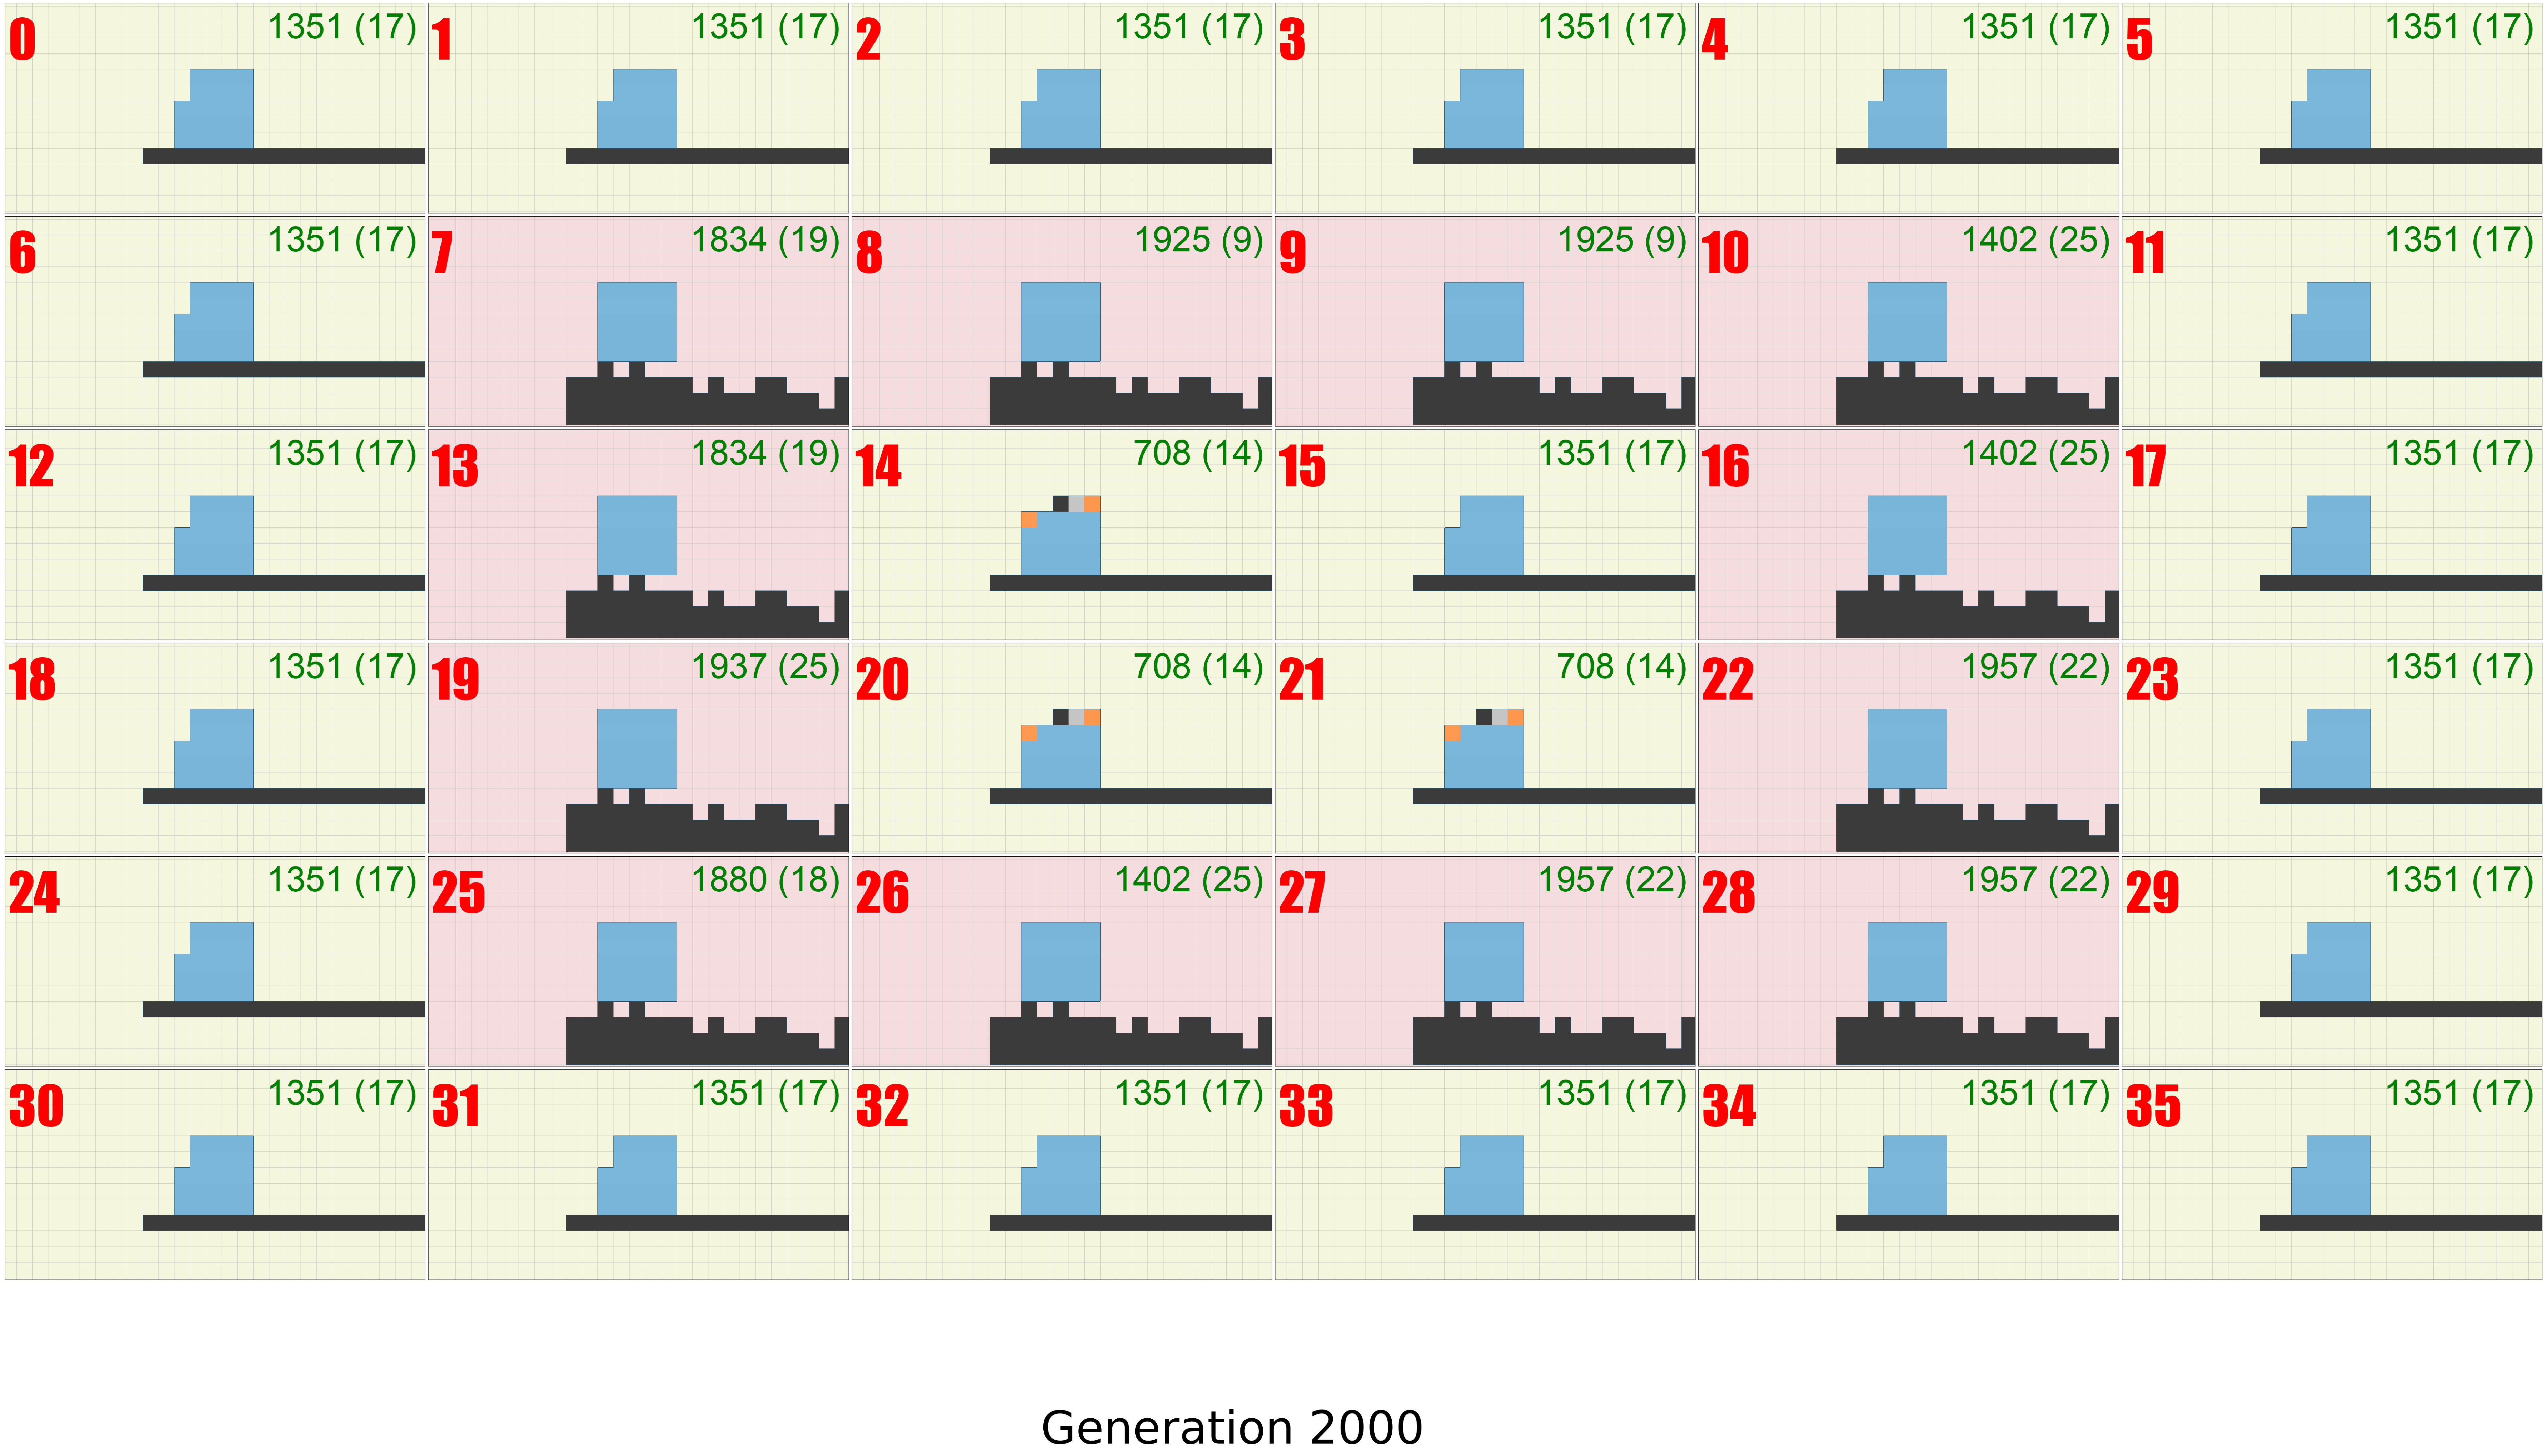

<Figure size 10000x10000 with 0 Axes>

In [8]:
n_rows=6
n_cols=6

fig = plt.figure(1,(100,100))
grid_img = ImageGrid(fig, 111,
                 nrows_ncols=(n_rows,n_cols),
                 axes_pad=0.1,
                 share_all=True
                 )

grid_img[0].get_yaxis().set_ticks([])
grid_img[0].get_xaxis().set_ticks([])
cont = 0
for key, value in grid.d_nodes.items():
    best_genome = None
    best_genome_fit = -100000
    for g in value.sgr_pop.pop.population.values():
        # print(g.key, g.fitness)
        if g.fitness != None and g.fitness > best_genome_fit:
            best_genome = g
            best_genome_fit = g.fitness
    # best_genome = value.sgr_pop.best_genome
    fit = np.round(best_genome_fit, 2)
    task = {value.task}
    # print(f" {best_genome.key} {fit}", end="\t")
    # if cont%n_cols==n_cols-1:
    #     print()
    
    robot, img = get_robot(best_genome, value.sgr_pop.neat_config, value.task, genome_type) 
    if img is not None:
        pil_img = Image.fromarray(img, 'RGB')    
        
        pil_img = apply_mas_by_task(pil_img, value.task)
        
        # Create a new Draw object for the image
        draw = ImageDraw.Draw(pil_img)

        # Define the caption text
        caption_text = f"{value.id}"
        font = ImageFont.truetype("impact.ttf", size=150)
        caption_size = draw.textsize(caption_text, font)
        caption_position = (20, 10)
        draw.text(caption_position, caption_text, font=font, fill="red")
        
#         caption_text = f"{value.task}"
#         font = ImageFont.truetype("arial.ttf", size=150)
#         caption_size = draw.textsize(caption_text, font)
#         caption_position = (pil_img.width // 2 - caption_size[0] // 2,15)
#         draw.text(caption_position, caption_text, font=font, fill="red")
        

        history = grid.d_historical[best_genome.key]
        caption_text = f"{best_genome.key} ({history.pop_id})"
        font = ImageFont.truetype("arial.ttf", size=100)
        caption_size = draw.textsize(caption_text, font)
        caption_position = (pil_img.width - caption_size[0] - 25, 10)
        draw.text(caption_position, caption_text, font=font, fill="green")
        
        
#         history = grid.d_historical[best_genome.key]
#         caption_text = f"g_id: {best_genome.key}, original_pop: {history.pop_id}, fit: {fit}"
#         font = ImageFont.truetype("arial.ttf", size=40)
#         caption_size = draw.textsize(caption_text, font)
#         caption_position = (pil_img.width // 2 - caption_size[0] // 2,15+caption_size[1])
#         draw.text(caption_position, caption_text, font=font, fill="black")
        
#         p1, p2 = history.parent_1, history.parent_2
#         caption_text = f"p1: {p1} ({grid.d_historical[p1].pop_id}), p2: {p2} ({grid.d_historical[p2].pop_id})"
#         font = ImageFont.truetype("arial.ttf", size=40)
#         caption_size = draw.textsize(caption_text, font)
#         caption_position = (pil_img.width // 2 - caption_size[0] // 2,15+caption_size[1]*2)
#         draw.text(caption_position, caption_text, font=font, fill="black")
        

        grid_img[cont].imshow(pil_img,interpolation='none')
    cont += 1
    
plt.rcParams.update({'font.size': 100})
fig.text(0.50, 0.25,  'Generation 2000', horizontalalignment='center', wrap=True) 
fig.savefig('my_plot_2.jpeg', pad_inches= 0.01)

display(fig)
_=plt.clf()

In [ ]:
fig.text(0.50, 0.25,  'Generation 2', horizontalalignment='center', wrap=True, size="xx-large" ) 
# display(fig)
# fig.savefig('my_plot_2.jpeg', pad_inches= 0.01)
# plt.clf()

In [6]:
for g in grid.d_nodes["8"].sgr_pop.pop.population.values():
    print(g.key, g.fitness)

1351 0.964588424313072
1867 0.9960335137461214
2045 None
1925 4.454962163041392
2046 None


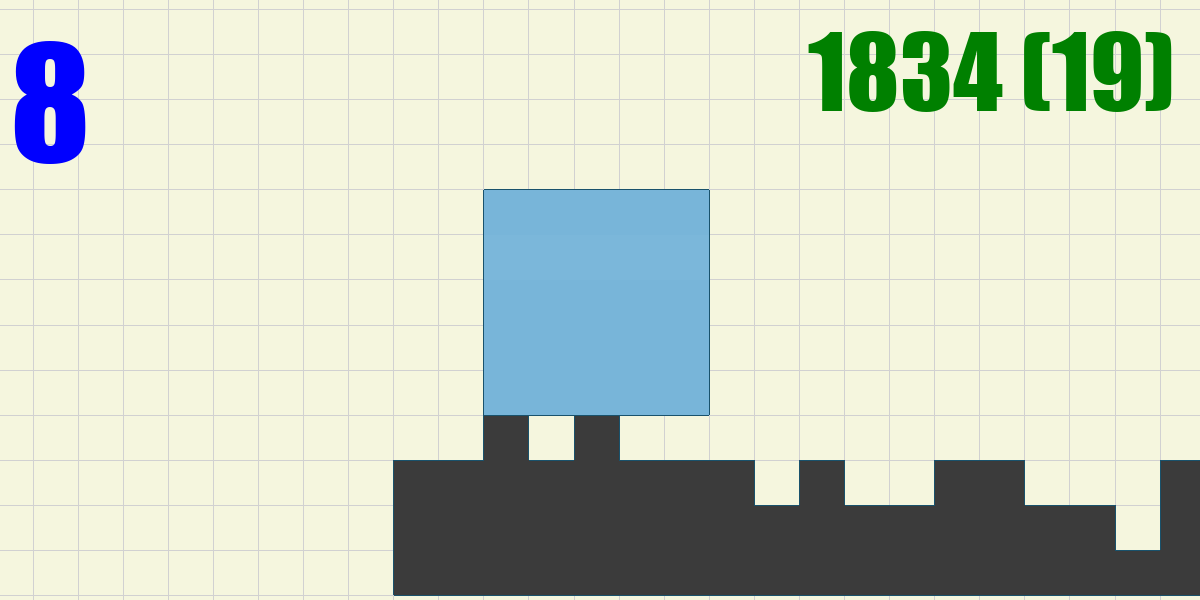

In [47]:
coord = grid.d_nodes["8"]
sgr_pop = coord.sgr_pop
best_genome = sgr_pop.pop.best_genome
robot, img = get_robot(best_genome, sgr_pop.neat_config, coord.task, genome_type) 

pil_img = Image.fromarray(img, 'RGB')    
# Apply the red filter
# Convert to grayscale
gray_image = pil_img.convert('L')

# Create a mask of the white parts of the image
threshold = 240  # You can adjust this value to capture more or less white
white_mask = gray_image.point(lambda x: x > threshold or 255)

# Create a red-tinted version of the white mask
red_filter = (255, 255, 0)  # (R, G, B) values for red
red_mask = ImageOps.colorize(white_mask, black=red_filter, white=(255, 255, 255))

# Blend the red-tinted mask with the original image
red_image = ImageChops.blend(pil_img, red_mask, 0.1)



# Create a new Draw object for the image
draw = ImageDraw.Draw(red_image)

# Define the caption text
caption_text = f"{coord.id}"
font = ImageFont.truetype("impact.ttf", size=150)
caption_size = draw.textsize(caption_text, font)
caption_position = (10, 10)
draw.text(caption_position, caption_text, font=font, fill="blue")

history = grid.d_historical[best_genome.key]
caption_text = f"{best_genome.key} ({history.pop_id})"
font = ImageFont.truetype("impact.ttf", size=100)
caption_size = draw.textsize(caption_text, font)
caption_position = (pil_img.width - caption_size[0] - 25, 10)
draw.text(caption_position, caption_text, font=font, fill="green")

display(red_image)

In [ ]:
grid.d_nodes["0"].sgr_pop.single_genome_fit(
    genome = grid.d_nodes["29"].sgr_pop.pop.population[2058],
    n_steps = 1000,
    env_name="ObstacleTraverser-v0",
    get_env_obs=None,
    dynamic_env_config=None,
    render=True, 
    save_gif=None,
)

In [6]:
grid.d_historical[515].__dict__

{'id': 515, 'pop_id': 23, 'parent_1': 312, 'parent_2': 312}

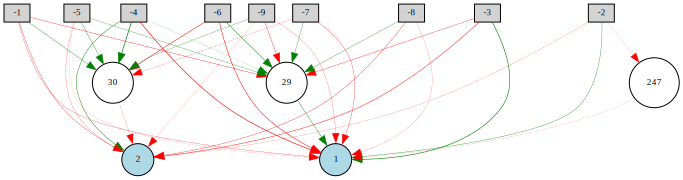

In [41]:
genome = grid.d_nodes["1"].sgr_pop.pop.population[12031]
cppn = neat.nn.FeedForwardNetwork.create(genome, grid.d_nodes["1"].sgr_pop.pop.config)
draw_net(cppn)

In [ ]:
grid.d_historical[best_genome.id].pop_id